In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pickle
import os
from torch import nn
import torch.nn.functional as F

# === Load embeddings and events ===
with open('/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_softmax.pkl', 'rb') as f:
    image_embeddings_dict = pickle.load(f)

image_embeddings = image_embeddings_dict['natural_scenes']  # (118, D)
image_embeddings_repeated = np.repeat(image_embeddings, 50, axis=0)  # (5900, D)
assert image_embeddings_repeated.shape[0] == 5900

events = np.load('/home/maria/Documents/AllenBrainObservatory/neural_activity_matrices/500860585_neural_responses.npy')  # (N_neurons, 5900)

# === Dataset ===
class NeuronVisionDataset(torch.utils.data.Dataset):
    def __init__(self, image_embeddings, neural_events):
        assert image_embeddings.shape[0] == neural_events.shape[1]
        self.image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32)
        self.neural_events = torch.tensor(neural_events.T, dtype=torch.float32)  # (5900, N_neurons)

    def __len__(self):
        return self.image_embeddings.shape[0]

    def __getitem__(self, idx):
        return {
            "image_embedding": self.image_embeddings[idx],   # (D,)
            "neural_activity": self.neural_events[idx]       # (N_neurons,)
        }

full_dataset = NeuronVisionDataset(image_embeddings_repeated, events)
full_loader = DataLoader(full_dataset, batch_size=4, shuffle=False)

# === Model ===
class PixelAttentionModel(nn.Module):
    def __init__(self, image_dim, neuron_dim, num_neurons, attention_dim=32):
        super().__init__()
        self.image_dim = image_dim
        self.neuron_dim = neuron_dim
        self.num_neurons = num_neurons
        self.feature_dim = image_dim + neuron_dim

        self.neuron_embeddings = nn.Parameter(torch.randn(num_neurons, neuron_dim))
        self.to_q = nn.Linear(1, attention_dim)
        self.to_k = nn.Linear(1, attention_dim)
        self.to_v = nn.Linear(1, attention_dim)
        self.output_proj = nn.Linear(self.feature_dim * attention_dim, 1)

    def forward(self, image_embedding, neuron_idx):
        B, D = image_embedding.shape
        neuron_idx = neuron_idx.to(torch.long)

        if neuron_idx.ndim == 1:
            K = 1
            neuron_emb = self.neuron_embeddings[neuron_idx]  # (B, D')
        elif neuron_idx.ndim == 2:
            K = neuron_idx.shape[1]
            neuron_emb = self.neuron_embeddings[neuron_idx]  # (B, K, D')
        else:
            raise ValueError("neuron_idx must be shape (B,) or (B, K)")

        if K == 1:
            image_exp = image_embedding  # (B, D)
        else:
            image_exp = image_embedding.unsqueeze(1).expand(-1, K, -1)  # (B, K, D)

        combined = torch.cat([image_exp, neuron_emb], dim=-1)  # (B, K, D + D')
        B_flat = B * K if K > 1 else B
        F_feat = self.feature_dim
        x = combined.view(B_flat, F_feat, 1)  # (B*K, F, 1)

        Q = self.to_q(x)
        K_ = self.to_k(x)
        V = self.to_v(x)

        attn_scores = torch.matmul(Q, K_.transpose(-2, -1)) / (Q.shape[-1] ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)  # (B*K, F, A)

        attn_out_flat = attn_out.view(B_flat, -1)
        output = self.output_proj(attn_out_flat).squeeze(-1)
        return output.view(B, K) if K > 1 else output.view(B)

# === Load model ===
image_dim = image_embeddings_repeated.shape[1]
num_neurons = events.shape[0]
neuron_dim = 32
attention_dim = 16

device = torch.device("cpu")
model = PixelAttentionModel(image_dim, neuron_dim, num_neurons, attention_dim)
model.load_state_dict(torch.load("/home/maria/LuckyMouse/notebooks/models/fold_1.pt", map_location=device))
model.to(device)
model.eval()

# === Evaluate accuracy on non-zero events only ===
per_neuron_correct = torch.zeros(num_neurons)
per_neuron_total = torch.zeros(num_neurons)

print("🔍 Evaluating each neuron (non-zero events only)...")
with torch.no_grad():
    for neuron_id in tqdm(range(num_neurons)):
        correct = 0
        total = 0

        for batch in full_loader:
            image_emb = batch["image_embedding"]  # (B, D)
            labels = batch["neural_activity"][:, neuron_id]  # (B,)

            nonzero_mask = labels == 1.0
            if nonzero_mask.sum() == 0:
                continue  # Skip this batch if no positive labels

            image_emb_nz = image_emb[nonzero_mask]
            labels_nz = labels[nonzero_mask]
            neuron_idx = torch.full((labels_nz.size(0),), neuron_id, dtype=torch.long)

            logits = model(image_emb_nz, neuron_idx)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            correct += (preds == labels_nz).sum().item()
            total += labels_nz.size(0)

        per_neuron_correct[neuron_id] = correct
        per_neuron_total[neuron_id] = total

# === Report results ===
valid_mask = per_neuron_total > 0
overall_accuracy = per_neuron_correct[valid_mask].sum().item() / per_neuron_total[valid_mask].sum().item()
per_neuron_accuracy = (per_neuron_correct / per_neuron_total).numpy()

print(f"\n✅ Overall accuracy on non-zero events: {overall_accuracy:.4f}")

for i, acc in enumerate(per_neuron_accuracy):
    if per_neuron_total[i] > 0:
        print(f"Neuron {i:3d} accuracy (non-zero only): {acc:.4f}")
    else:
        print(f"Neuron {i:3d} had no positive events.")


🔍 Evaluating each neuron (non-zero events only)...


100%|██████████| 155/155 [02:31<00:00,  1.02it/s]


✅ Overall accuracy on non-zero events: 0.0000
Neuron   0 accuracy (non-zero only): 0.0000
Neuron   1 accuracy (non-zero only): 0.0000
Neuron   2 accuracy (non-zero only): 0.0000
Neuron   3 accuracy (non-zero only): 0.0000
Neuron   4 accuracy (non-zero only): 0.0000
Neuron   5 accuracy (non-zero only): 0.0000
Neuron   6 accuracy (non-zero only): 0.0000
Neuron   7 accuracy (non-zero only): 0.0000
Neuron   8 accuracy (non-zero only): 0.0000
Neuron   9 accuracy (non-zero only): 0.0000
Neuron  10 accuracy (non-zero only): 0.0000
Neuron  11 accuracy (non-zero only): 0.0000
Neuron  12 accuracy (non-zero only): 0.0000
Neuron  13 accuracy (non-zero only): 0.0000
Neuron  14 accuracy (non-zero only): 0.0000
Neuron  15 accuracy (non-zero only): 0.0000
Neuron  16 accuracy (non-zero only): 0.0000
Neuron  17 accuracy (non-zero only): 0.0000
Neuron  18 accuracy (non-zero only): 0.0000
Neuron  19 accuracy (non-zero only): 0.0000
Neuron  20 accuracy (non-zero only): 0.0000
Neuron  21 accuracy (non-zero

🔎 Evaluating average predicted probabilities at spike (1) events...


100%|██████████| 155/155 [02:14<00:00,  1.16it/s]



✅ Average predicted probability on spike (1) events: 0.0365


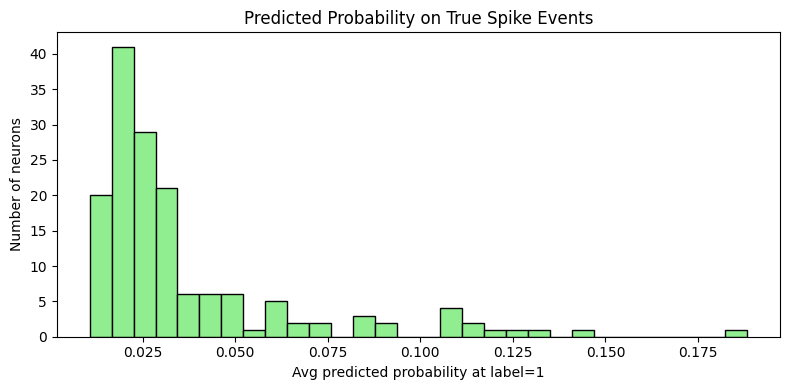

In [3]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F

# === Load embeddings and events ===
with open('/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_softmax.pkl', 'rb') as f:
    image_embeddings_dict = pickle.load(f)

image_embeddings = image_embeddings_dict['natural_scenes']
image_embeddings_repeated = np.repeat(image_embeddings, 50, axis=0)
assert image_embeddings_repeated.shape[0] == 5900

events = np.load('/home/maria/Documents/AllenBrainObservatory/neural_activity_matrices/500860585_neural_responses.npy')

# === Dataset ===
class NeuronVisionDataset(torch.utils.data.Dataset):
    def __init__(self, image_embeddings, neural_events):
        assert image_embeddings.shape[0] == neural_events.shape[1]
        self.image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32)
        self.neural_events = torch.tensor(neural_events.T, dtype=torch.float32)

    def __len__(self):
        return self.image_embeddings.shape[0]

    def __getitem__(self, idx):
        return {
            "image_embedding": self.image_embeddings[idx],
            "neural_activity": self.neural_events[idx]
        }

full_dataset = NeuronVisionDataset(image_embeddings_repeated, events)
full_loader = DataLoader(full_dataset, batch_size=4, shuffle=False)

# === Model ===
class PixelAttentionModel(nn.Module):
    def __init__(self, image_dim, neuron_dim, num_neurons, attention_dim=32):
        super().__init__()
        self.image_dim = image_dim
        self.neuron_dim = neuron_dim
        self.num_neurons = num_neurons
        self.feature_dim = image_dim + neuron_dim

        self.neuron_embeddings = nn.Parameter(torch.randn(num_neurons, neuron_dim))
        self.to_q = nn.Linear(1, attention_dim)
        self.to_k = nn.Linear(1, attention_dim)
        self.to_v = nn.Linear(1, attention_dim)
        self.output_proj = nn.Linear(self.feature_dim * attention_dim, 1)

    def forward(self, image_embedding, neuron_idx):
        B, D = image_embedding.shape
        neuron_idx = neuron_idx.to(torch.long)

        if neuron_idx.ndim == 1:
            K = 1
            neuron_emb = self.neuron_embeddings[neuron_idx]
        elif neuron_idx.ndim == 2:
            K = neuron_idx.shape[1]
            neuron_emb = self.neuron_embeddings[neuron_idx]
        else:
            raise ValueError("neuron_idx must be shape (B,) or (B, K)")

        if K == 1:
            image_exp = image_embedding
        else:
            image_exp = image_embedding.unsqueeze(1).expand(-1, K, -1)

        combined = torch.cat([image_exp, neuron_emb], dim=-1)
        B_flat = B * K if K > 1 else B
        F_feat = self.feature_dim
        x = combined.view(B_flat, F_feat, 1)

        Q = self.to_q(x)
        K_ = self.to_k(x)
        V = self.to_v(x)

        attn_scores = torch.matmul(Q, K_.transpose(-2, -1)) / (Q.shape[-1] ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_out = torch.matmul(attn_weights, V)
        attn_out_flat = attn_out.view(B_flat, -1)
        output = self.output_proj(attn_out_flat).squeeze(-1)
        return output.view(B, K) if K > 1 else output.view(B)

# === Load model ===
image_dim = image_embeddings_repeated.shape[1]
num_neurons = events.shape[0]
neuron_dim = 32
attention_dim = 16

device = torch.device("cpu")
model = PixelAttentionModel(image_dim, neuron_dim, num_neurons, attention_dim)
model.load_state_dict(torch.load("/home/maria/LuckyMouse/notebooks/models/fold_1.pt", map_location=device))
model.to(device)
model.eval()

# === Compute predicted probability at label=1 events ===
per_neuron_sum_probs = torch.zeros(num_neurons)
per_neuron_counts = torch.zeros(num_neurons)

print("🔎 Evaluating average predicted probabilities at spike (1) events...")
with torch.no_grad():
    for neuron_id in tqdm(range(num_neurons)):
        prob_sum = 0.0
        count = 0

        for batch in full_loader:
            image_emb = batch["image_embedding"]  # (B, D)
            labels = batch["neural_activity"][:, neuron_id]  # (B,)

            mask = labels == 1.0
            if mask.sum() == 0:
                continue

            image_emb_nz = image_emb[mask]
            neuron_idx = torch.full((image_emb_nz.size(0),), neuron_id, dtype=torch.long)
            logits = model(image_emb_nz, neuron_idx)
            probs = torch.sigmoid(logits)

            prob_sum += probs.sum().item()
            count += len(probs)

        per_neuron_sum_probs[neuron_id] = prob_sum
        per_neuron_counts[neuron_id] = count

# === Compute average predicted probability at 1s ===
valid = per_neuron_counts > 0
avg_prob_per_neuron = torch.zeros_like(per_neuron_sum_probs)
avg_prob_per_neuron[valid] = per_neuron_sum_probs[valid] / per_neuron_counts[valid]

overall_avg_prob = avg_prob_per_neuron[valid].mean().item()
print(f"\n✅ Average predicted probability on spike (1) events: {overall_avg_prob:.4f}")

# === Plot histogram ===
plt.figure(figsize=(8, 4))
plt.hist(avg_prob_per_neuron[valid].cpu().numpy(), bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("Avg predicted probability at label=1")
plt.ylabel("Number of neurons")
plt.title("Predicted Probability on True Spike Events")
plt.tight_layout()
plt.show()
